# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем необходимые библиотеки, а также изучим данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:

df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(df_0.head())
display(df_1.head())
display(df_2.head())


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
df_0.info()
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
df_1.info()
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
df_2.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

<class 'pandas.core.frame.DataFrame'>

Ran

In [4]:
print(f'Размер датасета geo_data_0 = {df_0.shape}')
print(f'Размер датасета geo_data_1 = {df_1.shape}')
print(f'Размер датасета geo_data_2 = {df_2.shape}')

Размер датасета geo_data_0 = (100000, 5)

Размер датасета geo_data_1 = (100000, 5)

Размер датасета geo_data_2 = (100000, 5)


In [5]:
display(df_0.describe())
display(df_1.describe())
display(df_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
def make_hist(df, name):
    n_bins=4
    
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    
    fig.suptitle(name, fontsize=16)
     
    
    ax0.hist(df['f0'], n_bins, histtype='bar')
    ax0.set_title('f0')
    ax0.set_xlabel('Value')
    ax0.set_ylabel('Amount')
    
    ax1.hist(df['f1'], n_bins, histtype='bar')
    ax1.set_title('f1')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Amount')
    
    ax2.hist(df['f2'], n_bins, histtype='bar')
    ax2.set_title('f2')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Amount')
    
    ax3.hist(df['product'], n_bins, histtype='bar')
    ax3.set_title('product')
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Amount, thousand barrels')
    
    fig.tight_layout()
    plt.show()

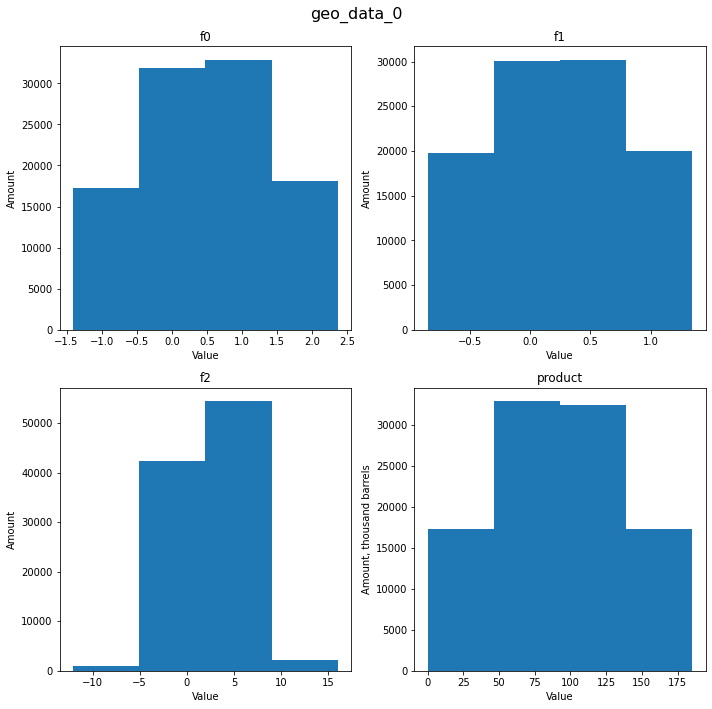

In [7]:
make_hist(df_0, "geo_data_0")

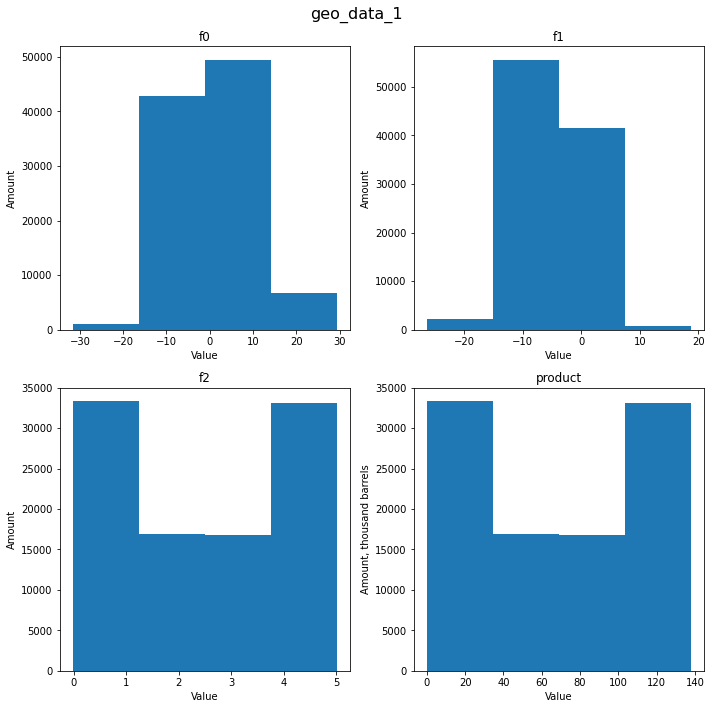

In [8]:
make_hist(df_1, "geo_data_1")

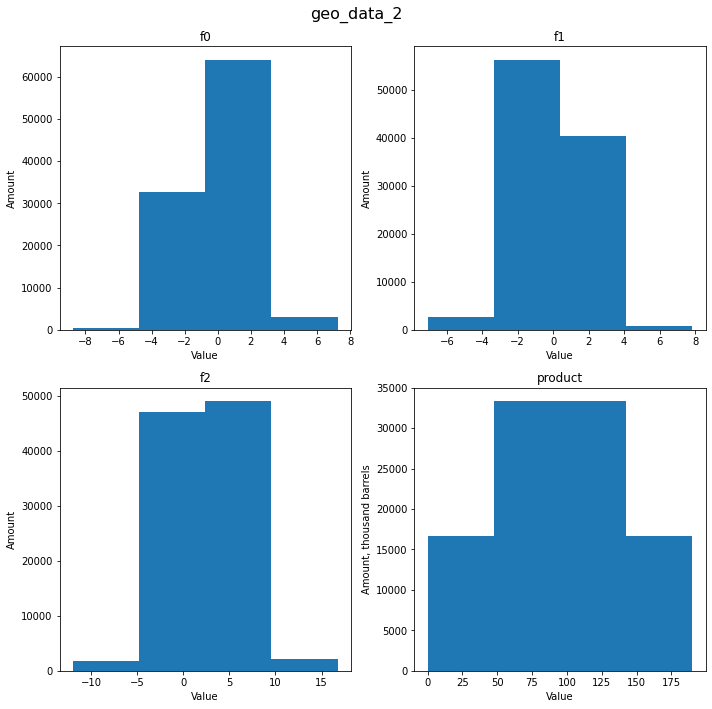

In [9]:
make_hist(df_2, "geo_data_2")

#### Вывод

На гистограммах рассмотрим распределение значений для каждого из набора данных. Особых вывыодов относиельно адекватности f0,f1,f2 мы сделать не можем, так как данные синтетические, однако же можем рассмотреть product. Для geo_data_0 и geo_data_2 мы видим нормальное распределение, однако же geo_data_1 существенно отличается от них. Никаких выводов относительно адекватности этого мы делать не будем, однако же возьмем это на заметку.

### Перейдем к предобработке

In [10]:
df_0.duplicated().sum()

0

In [11]:
df_1.duplicated().sum()

0

In [12]:
df_2.duplicated().sum()

0

In [13]:
df_0['id'].value_counts()

74z30    2
AGS9W    2
fiKDv    2
TtcGQ    2
Tdehs    2
        ..
Qpq5c    1
5PGl2    1
RUsZb    1
LZduu    1
7u40q    1
Name: id, Length: 99990, dtype: int64

In [14]:
df_1['id'].value_counts()

5ltQ6    2
LHZR0    2
bfPNe    2
wt4Uk    2
KqYDx    1
        ..
4FS7u    1
L7guQ    1
tq0Vb    1
gC7dT    1
oqmlo    1
Name: id, Length: 99996, dtype: int64

In [15]:
df_2['id'].value_counts()

VF7Jo    2
xCHr8    2
Vcm5J    2
KUPhW    2
Mctkn    1
        ..
PdFDV    1
BdgUq    1
Z3Z5w    1
oAsuh    1
Bdn9F    1
Name: id, Length: 99996, dtype: int64

Похоже, что скважины измеряли многократно, либо уникальный id не такой уж и уникальный. В любом случае для обучения данный признак нам никак не поможет, поэтому просто уберем его.

In [16]:
df_0.drop(columns='id', inplace=True)
df_1.drop(columns='id', inplace=True)
df_2.drop(columns='id', inplace=True)

In [17]:
df_0.info()
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
df_1.info()
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
df_2.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 4 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   f0       100000 non-null  float64

 1   f1       100000 non-null  float64

 2   f2       100000 non-null  float64

 3   product  100000 non-null  float64

dtypes: float64(4)

memory usage: 3.1 MB

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 4 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   f0       100000 non-null  float64

 1   f1       100000 non-null  float64

 2   f2       100000 non-null  float64

 3   product  100000 non-null  float64

dtypes: float64(4)

memory usage: 3.1 MB

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 4 columns):

 #   Column   Non-Null Count   Dty

In [18]:
data = dict()
data[0] = df_0
data[1] = df_1
data[2] = df_2

### Вывод

В данном разделе мы познакомились с данными и устранили ненужный нам признак id, который никак не повлияет на результаты обучения. На данном этапе данный готовы для обучения на модели.

## Обучение и проверка модели

### Моделирование

Выделим признаки и целевые значения

In [19]:
features = dict()
target = dict()
features_train = dict()
features_valid = dict()
target_train = dict()
target_valid = dict()
model = dict()
predict_valid = dict()

In [20]:
def fit_model(region_num):
    features[region_num] = data[region_num].drop('product', axis=1)
    target[region_num] = data[region_num]['product']
    
    features_train[region_num], features_valid[region_num], target_train[region_num], target_valid[region_num] = train_test_split(
    features[region_num], target[region_num], train_size=0.75, random_state=12345)
    
    print(features_train[region_num].shape)
    print(features_valid[region_num].shape)
    
    scaler = StandardScaler()
    scaler.fit(features_train[region_num])
    
    features_train[region_num] = scaler.transform(features_train[region_num])
    features_valid[region_num] = scaler.transform(features_valid[region_num])
    
    model[region_num] = LinearRegression()
    
    model[region_num].fit(features_train[region_num], target_train[region_num])
    
    predict_valid[region_num] = model[region_num].predict(features_valid[region_num])
    
    print('rmse: ', mean_squared_error(target_valid[region_num], predict_valid[region_num], squared=False))

In [21]:
fit_model(0)

(75000, 3)

(25000, 3)

rmse:  37.5794217150813


In [22]:
fit_model(1)

(75000, 3)

(25000, 3)

rmse:  0.893099286775617


In [23]:
fit_model(2)

(75000, 3)

(25000, 3)

rmse:  40.02970873393434


<AxesSubplot:>

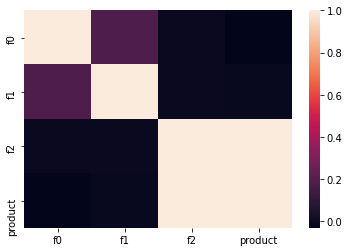

In [24]:
sns.heatmap(df_1.corr())

In [25]:
df_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


### Вывод

В данном разделе было произведено моделирование и обучение модели. В ходе данных этапов было произведено разделение выборки на тернировочную и валидационную в отношении 75:25, данные были промастштабированны. Получили следующие rmse у трех моделей регрессии:
- Регион 0, rmse:  37.5794217150813
- Регион 1, rmse:  0.893099286775617
- Регион 2, rmse:  40.02970873393434

Однако данные результаты неудивительны при такой кореляции.

## Подготовка к расчёту прибыли

Выделим константы

In [26]:
budget = 10000000000
amount_total = 500
amount_research = 200
revenue_product = 450000
min_product_hole = budget / (amount_research * revenue_product)

print('Минимальное количество продукта для выхода в 0:', min_product_hole)

Минимальное количество продукта для выхода в 0: 111.11111111111111


Выпишем функцию для рассчета прибыли

In [27]:
def revenue(target,probabilities,count):
    probs_sorted = probabilities.sort_values(ascending=False)
    
    selected = target[probs_sorted.index][:count]
    
    return revenue_product * selected.sum() - budget

## Расчёт прибыли и рисков 

In [28]:
def result_region(region_num, target, predictions):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=amount_total, replace=True, random_state=state)
        probs_subsample = pd.Series(predictions)[target_subsample.index]
        
        values.append(revenue(target_subsample, probs_subsample, amount_research))
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    risk = (values < 0).mean() * 100
    
    print(f'Средняя прибыль в регионе: {round(values.mean())} руб. ')
    print(f'95% доверительный интервал: ({lower}, {upper})')
    print(f'Риск убытка: {risk} ')

In [29]:
result_region(0, target_valid[0], predict_valid[0])

Средняя прибыль в регионе: 425938527 руб. 

95% доверительный интервал: (-102090094.83793654, 947976353.3583689)

Риск убытка: 6.0 


In [30]:
result_region(1, target_valid[1], predict_valid[1])

Средняя прибыль в регионе: 515222773 руб. 

95% доверительный интервал: (68873225.37050176, 931547591.2570494)

Риск убытка: 1.0 


In [31]:
result_region(2,target_valid[2], predict_valid[2])

Средняя прибыль в регионе: 435008363 руб. 

95% доверительный интервал: (-128880547.32978901, 969706954.1802661)

Риск убытка: 6.4 


### Вывод

Подходящим для нас является второй регион, однако помним, что в исходных данных слишком высокая корреляция между product и f2.

## Общий вывод

В ходе данной работы были изучены данные добывающей компании «ГлавРосГосНефть» в трех регионах.

Была выполнена предобработка данных, в ходе которой:
-  Устранили ненужный нам признак id, который никак не повлияет на результаты обучения

Было произведено обучение модели линейной регрессии, которая дала наилучшие результаты на втором регионе, однако позже была также обнаружена высокая корреляция между признаком f2 и product.

Была произведена подготовка и рассчет прибыли во всех регионах. Самым лучшим оказался второй регион со следующими результатами:
- Средняя прибыль в регионе: 515222773. 
- 95% доверительный интервал: (68873225.37050176, 931547591.2570494)
- Риск убытка: 1.0 